In [1]:
cd /content/drive/MyDrive/Colab Notebooks/VAE

/content/drive/MyDrive/Colab Notebooks/VAE


In [2]:
filename = ''

In [3]:
pip install tensorboardX

In [4]:
import torch
from torch import nn, optim  
import torch.nn.functional as F
import pandas as pd
import torchvision
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import os
from utils import Logger

In [5]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="~/datasets", train=True, transform=transform, download=True
) 

In [6]:
n_features = 28*28

In [7]:
logger = Logger(model_name='AE', data_name='MNIST')

In [8]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__() 
    self.encoder = nn.Sequential(
        nn.Linear(in_features=n_features, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=128), 
    )
    self.decoder = nn.Sequential(
        nn.Linear(in_features=128, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=n_features), 
    )

  def forward(self, x):
    x = F.relu(self.encoder(x))
    x = F.relu(self.decoder(x))
    return x

In [9]:
def vector_to_image(image):
  return image.view(image.shape[0], 1, 28, 28)

In [10]:
has_gpu = torch.cuda.is_available() 
# batch size
batch_size = 64

autoencoder = AutoEncoder()

In [11]:
if has_gpu:
  autoencoder = autoencoder.cuda()
else:
  autoencoder = autoencoder

print(autoencoder)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
  )
)


In [12]:
ae_optim = optim.Adam(autoencoder.parameters(), lr=0.001)

# loss function
loss = nn.MSELoss()

# Number of epochs
num_epochs = 20


In [13]:
data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

In [14]:
for epoch in range(num_epochs): # loop over dataset
    loss_log = 0  
    for n_batch, (train_data, _) in enumerate(data_loader):  

        train_data  = Variable(train_data.view(-1, n_features))

        if has_gpu: train_data = train_data.cuda()

        # reset the gradients back to zero
        ae_optim.zero_grad()

        # compute reconstruction 
    
        reconstructed = autoencoder(train_data)

        # compute the loss 
        train_loss = loss(reconstructed, train_data)  

        # backpropagate the gradient 
        train_loss.backward()

        # update parameter update based on current gradients
        ae_optim.step()
        loss_log += train_loss.item()
    
    # Log the image
    #if(epoch) % 25 == 0:
        #logger.log_images(images = vector_to_image(reconstructed[0:16]).data.cpu(), num_images = 16, epoch=epoch, n_batch = n_batch,  num_batches=batch_size)
    # epoch loss 
    loss_log = loss_log / len(train_data)

    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, num_epochs, loss_log))

epoch : 1/20, loss = 0.153412
epoch : 2/20, loss = 0.083910
epoch : 3/20, loss = 0.073836
epoch : 4/20, loss = 0.069306
epoch : 5/20, loss = 0.066372
epoch : 6/20, loss = 0.064431
epoch : 7/20, loss = 0.062759
epoch : 8/20, loss = 0.061411
epoch : 9/20, loss = 0.060342
epoch : 10/20, loss = 0.059506
epoch : 11/20, loss = 0.058783
epoch : 12/20, loss = 0.058168
epoch : 13/20, loss = 0.057664
epoch : 14/20, loss = 0.057226
epoch : 15/20, loss = 0.056787
epoch : 16/20, loss = 0.056421
epoch : 17/20, loss = 0.056107
epoch : 18/20, loss = 0.055815
epoch : 19/20, loss = 0.055545
epoch : 20/20, loss = 0.055291


In [17]:
def plot_images(model,
                image,
                show=True,
                step=0,
                model_name="auto_encoder"):
    """Generate fake images and plot them
    For visualization purposes, generate fake images
    then plot them in a square grid
    # Arguments
        model (Models): 
        show (bool): Whether to show plot or not
        step (int): Appended to filename of the save images
        model_name (string): Model name
    """
    images = model(image).cpu().detach()
    print(model_name,
          "Labels for generated images: ")
    print("image size", images.shape)
    plt.figure(figsize=(12, 12))
    num_images = images.shape[0]
    image_size = 28
    
    rows =  int(np.sqrt(num_images))*2  #int(math.sqrt(noise_class.shape[0]))
    print("ROWS", rows)
    for i in range(num_images): 
        plt.subplot(rows, rows, i + 1)
        img2 = np.reshape(image[i].cpu().detach(), [image_size, image_size]) 
        plt.imshow(img2, cmap='gray')
        plt.axis('off')

        plt.subplot(rows, rows, num_images + i + 1)
        img = np.reshape(images[i], [image_size, image_size])  
        plt.imshow(img, cmap='gray') 
        plt.axis('off')
    save_images(plt)
    if show:
        plt.show()
    else:
        plt.close('all')

torch.Size([16, 784])
auto_encoder Labels for generated images: 
image size torch.Size([16, 784])
ROWS 8
[Errno 17] File exists: './data/images/mnist'


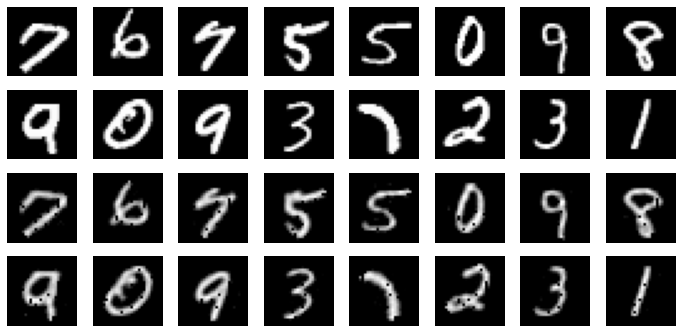

In [19]:
img = Variable(train_data[0:16].view(-1, n_features)) #Variable(train_dataset.train_data[0].view(-1, n_features)).cuda()

img = img.cuda()

print(img.shape)
plot_images(autoencoder, img)

In [18]:
data_subdir = 'mnist'
def make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
          print(e)
        #    if e.errno != errno.EEXIST:
        #       raise

def save_images(fig, epoch=0, n_batch=0, comment=''):
        out_dir = './data/images/{}'.format(data_subdir)
        make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir, comment, epoch, n_batch))